<a href="https://colab.research.google.com/github/Ninja-draw-coder/PythonProjects/blob/main/JuliusAI_HeartDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code Explanation
This code snippet imports necessary libraries, loads the heart disease dataset, and visualizes the target distribution.
- Import libraries for data manipulation, visualization, and machine learning.
- Load the heart disease dataset from a CSV file.
- Print the shape and head of the dataset.
- Create a count plot to visualize the distribution of the target variable.

Shape of data: (253680, 16)
Head:
   HeartDiseaseorAttack  HighBP  HighChol   BMI  Smoker  Diabetes  \
0                   0.0     1.0       1.0  40.0     1.0       0.0   
1                   0.0     0.0       0.0  25.0     1.0       0.0   
2                   0.0     1.0       1.0  28.0     0.0       0.0   
3                   0.0     1.0       0.0  27.0     0.0       0.0   
4                   0.0     1.0       1.0  24.0     0.0       0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  MentHlth  PhysHlth  Sex  \
0           0.0     0.0      1.0                0.0      18.0      15.0  0.0   
1           1.0     0.0      0.0                0.0       0.0       0.0  0.0   
2           0.0     1.0      0.0                0.0      30.0      30.0  0.0   
3           1.0     1.0      1.0                0.0       0.0       0.0  0.0   
4           1.0     1.0      1.0                0.0       3.0       0.0  0.0   

    Age  Education  Income  
0   9.0        4.0     3.0  
1   7.0     

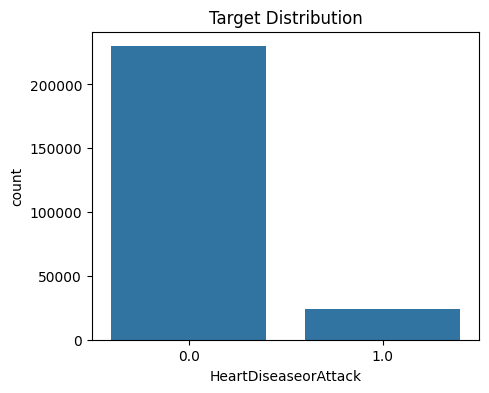

In [1]:
# Step 1: Import common libraries and load heart disease dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load dataset
df = pd.read_csv('heartdisease.csv')

print('Shape of data:', df.shape)
print('\
Head:')
print(df.head())

# Target distribution
plt.figure(figsize=(5,4))
sns.countplot(x='HeartDiseaseorAttack', data=df)
plt.title('Target Distribution')
plt.show()

Code Explanation
The code performed univariate analysis, engineered features, and built several classification models to predict heart disease outcomes.
- Plotted univariate distributions for numeric features
- Created a correlation heatmap
- Engineered BMI categories and age groups
- Prepared data for modeling by encoding categorical features
- Split data into training and testing sets
- Defined and trained multiple classification models
- Evaluated models using precision-recall metrics
- Extracted and visualized feature importance from the Random Forest model

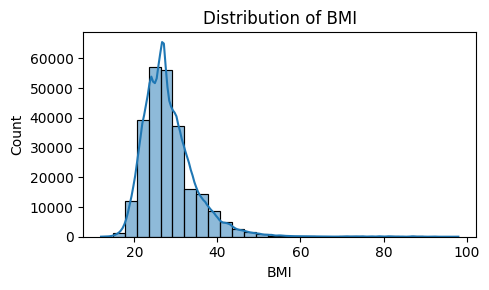

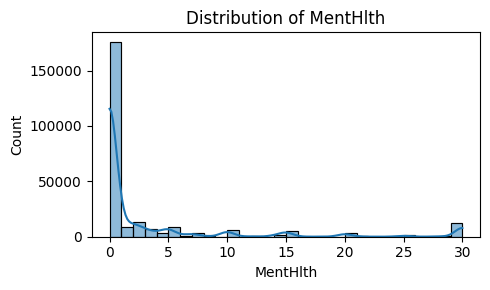

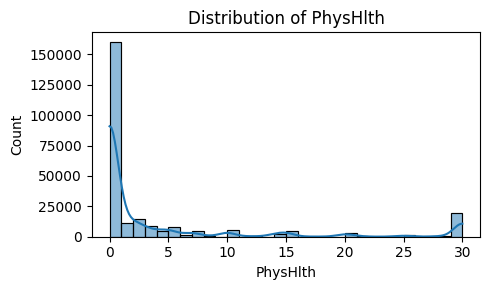

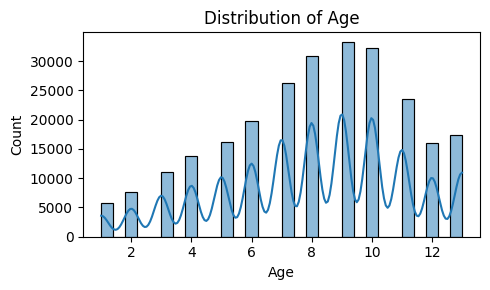

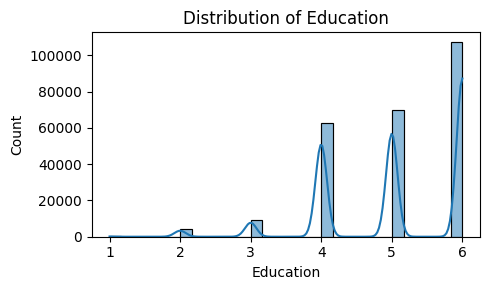

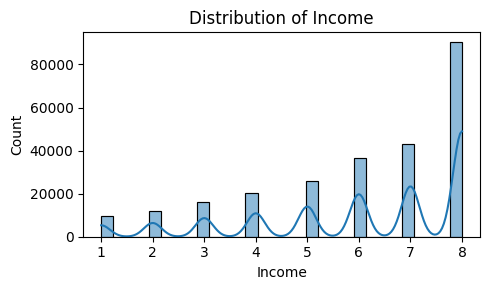

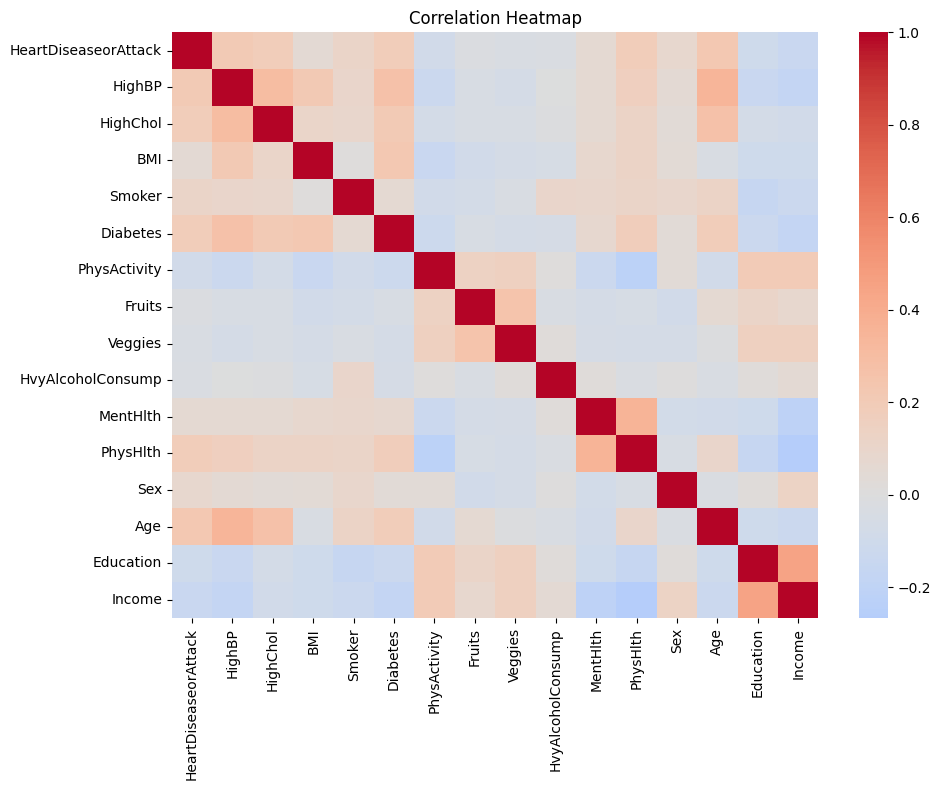

New feature columns added: BMI_cat, Age_grp


KeyError: '1'

In [2]:
# Continue analysis with univariate distributions and correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['BMI', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

# Univariate distributions
for col in numeric_cols:
    plt.figure(figsize=(5,3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title('Distribution of ' + col)
    plt.tight_layout()
    plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
cor = df.corr()
sns.heatmap(cor, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Feature engineering: create BMI category and Age group
bins_bmi = [0,18.5,25,30,100]
labels_bmi = ['Under/Normal','Overweight','Obese','Severely Obese']
df['BMI_cat'] = pd.cut(df['BMI'], bins=bins_bmi, labels=labels_bmi)

bins_age = [0,5,9,11,13]
labels_age = ['18-34','35-44','45-54','55+']
df['Age_grp'] = pd.cut(df['Age'], bins=bins_age, labels=labels_age)

print('New feature columns added: BMI_cat, Age_grp')

# Prepare data for modeling (convert categorical engineered features)
X = df.drop('HeartDiseaseorAttack', axis=1)
y = df['HeartDiseaseorAttack']

# One-hot encode categorical columns
categorical_cols = ['BMI_cat','Age_grp']

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

num_cols = [c for c in X.columns if c not in categorical_cols]

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier()
}

results = []
pr_curves = {}

for name, model in models.items():
    pipe = ImbPipeline(steps=[('pre', preprocess), ('smote', SMOTE(random_state=42)), ('clf', model)])
    pipe.fit(X_train, y_train)
    y_scores = pipe.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    avg_prec = average_precision_score(y_test, y_scores)
    y_pred_default = (y_scores>=0.5).astype(int)
    report = classification_report(y_test, y_pred_default, output_dict=True)
    results.append({'Model': name, 'PR_AUC': pr_auc, 'AvgPrecision': avg_prec, 'Precision': report['1']['precision'], 'Recall': report['1']['recall'], 'F1': report['1']['f1-score']})
    pr_curves[name] = (precision, recall)

# Results table
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

# Plot PR curves
plt.figure(figsize=(6,5))
for name, (precision, recall) in pr_curves.items():
    plt.plot(recall, precision, label=name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance from RandomForest
best_model = models['RandomForest']
pipe_rf = ImbPipeline(steps=[('pre', preprocess), ('smote', SMOTE(random_state=42)), ('clf', best_model)])
pipe_rf.fit(X_train, y_train)

# Extract feature names after preprocessing
onehot = pipe_rf.named_steps['pre'].named_transformers_['cat']
cat_feature_names = onehot.get_feature_names_out(categorical_cols)
all_features = num_cols + list(cat_feature_names)
importances = pipe_rf.named_steps['clf'].feature_importances_
fi_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(10)
print(fi_df)

# Plot feature importance
plt.figure(figsize=(6,4))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title('Top 10 Feature Importances (RF)')
plt.tight_layout()
plt.show()

In [3]:
# Identify if y_test has positive class
import numpy as np
print('Counts in y_test:', np.bincount(y_test))
# Also inspect classification_report dictionary keys for first model to see
pipe_temp = ImbPipeline(steps=[('pre', preprocess), ('smote', SMOTE(random_state=42)), ('clf', LogisticRegression(max_iter=1000))])
pipe_temp.fit(X_train, y_train)
y_scores_temp = pipe_temp.predict_proba(X_test)[:,1]
y_pred_temp = (y_scores_temp>=0.5).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_temp, output_dict=True).keys())

Counts in y_test: [45957  4779]
dict_keys(['0.0', '1.0', 'accuracy', 'macro avg', 'weighted avg'])


Code Explanation
This code snippet trains multiple classification models on heart disease data, evaluates their performance using precision-recall metrics, and visualizes feature importance for the Random Forest model.
- Converted target variable to integer type.
- Prepared feature and target datasets.
- Defined preprocessing steps for numerical and categorical features.
- Split data into training and testing sets with stratification.
- Initialized and trained multiple models (Logistic Regression, Random Forest, Gradient Boosting).
- Calculated precision-recall metrics and stored results for each model.
- Plotted precision-recall curves for model comparison.
- Trained Random Forest model and extracted feature importances.
- Visualized top 10 important features using a bar plot.

              Model    PR_AUC  AvgPrecision  Precision    Recall        F1
0            LogReg  0.307560      0.307796   0.225290  0.783637  0.349967
1      RandomForest  0.240699      0.239670   0.308934  0.172212  0.221147
2  GradientBoosting  0.298653      0.298898   0.316142  0.434819  0.366103


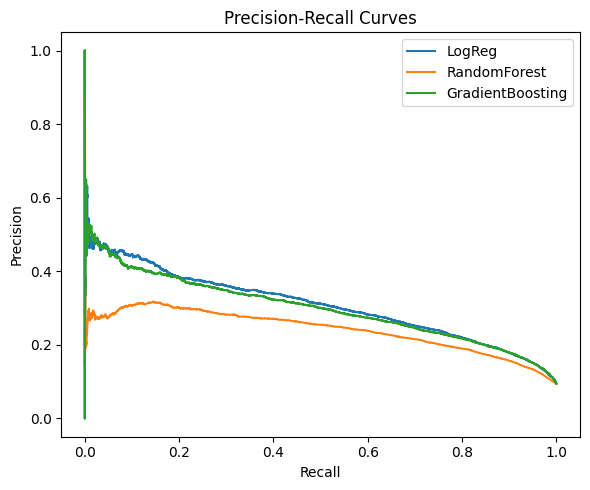

        Feature  Importance
12          Age    0.198797
14       Income    0.120977
10     PhysHlth    0.107797
2           BMI    0.100756
0        HighBP    0.070626
13    Education    0.064509
1      HighChol    0.048385
9      MentHlth    0.043271
11          Sex    0.029721
20  Age_grp_55+    0.029423


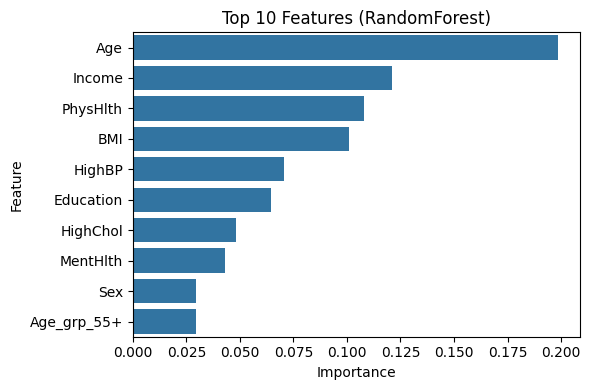

In [4]:
# Fix: convert target to int to have consistent class names

df['HeartDiseaseorAttack'] = df['HeartDiseaseorAttack'].astype(int)

# Re-prepare data
X = df.drop('HeartDiseaseorAttack', axis=1)
y = df['HeartDiseaseorAttack']

categorical_cols = ['BMI_cat','Age_grp']
num_cols = [c for c in X.columns if c not in categorical_cols]

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier()
}

results = []
pr_curves = {}

for name, model in models.items():
    pipe = ImbPipeline(steps=[('pre', preprocess), ('smote', SMOTE(random_state=42)), ('clf', model)])
    pipe.fit(X_train, y_train)
    y_scores = pipe.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    avg_prec = average_precision_score(y_test, y_scores)
    y_pred_default = (y_scores>=0.5).astype(int)
    report = classification_report(y_test, y_pred_default, output_dict=True)
    results.append({'Model': name, 'PR_AUC': pr_auc, 'AvgPrecision': avg_prec, 'Precision': report['1']['precision'], 'Recall': report['1']['recall'], 'F1': report['1']['f1-score']})
    pr_curves[name] = (precision, recall)

results_df = pd.DataFrame(results)
print(results_df)

# PR curves
plt.figure(figsize=(6,5))
for name, (precision, recall) in pr_curves.items():
    plt.plot(recall, precision, label=name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance (RF)
pipe_rf = ImbPipeline(steps=[('pre', preprocess), ('smote', SMOTE(random_state=42)), ('clf', models['RandomForest'])])
pipe_rf.fit(X_train, y_train)

onehot = pipe_rf.named_steps['pre'].named_transformers_['cat']
cat_feature_names = onehot.get_feature_names_out(categorical_cols)
all_features = num_cols + list(cat_feature_names)
importances = pipe_rf.named_steps['clf'].feature_importances_
fi_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(10)
print(fi_df)

plt.figure(figsize=(6,4))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title('Top 10 Features (RandomForest)')
plt.tight_layout()
plt.show()

In [ ]:
# Train final Gradient Boosting pipeline on full data (with SMOTE within cross-val not needed since final training use full data)
from joblib import dump

# Recreate preprocessing and pipeline
df = pd.read_csv('heartdisease.csv')
df['HeartDiseaseorAttack'] = df['HeartDiseaseorAttack'].astype(int)

# Feature engineering
df['BMI_cat'] = pd.cut(df['BMI'], bins=[0,18.5,25,30,100], labels=['Under/Normal','Overweight','Obese','Severely Obese'])
df['Age_grp'] = pd.cut(df['Age'], bins=[0,5,9,11,13], labels=['18-34','35-44','45-54','55+'])

X = df.drop('HeartDiseaseorAttack', axis=1)
y = df['HeartDiseaseorAttack']

categorical_cols = ['BMI_cat','Age_grp']
num_cols = [c for c in X.columns if c not in categorical_cols]

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

final_pipe = ImbPipeline(steps=[('pre', preprocess), ('smote', SMOTE(random_state=42)), ('clf', GradientBoostingClassifier())])
final_pipe.fit(X, y)

# Save model
model_filename = 'heart_disease_gradient_pipeline.pkl'
dump(final_pipe, model_filename)
print('Saved model to', model_filename)

# Generate probabilities on a sample of 5 random patients
sample = X.sample(5, random_state=1)
probs = final_pipe.predict_proba(sample)[:,1]
print('Sample probabilities:')
print(probs)

# Permutation importance to get drivers
from sklearn.inspection import permutation_importance
r = permutation_importance(final_pipe, X, y, n_repeats=10, random_state=0, n_jobs=-1)

# Feature names after preprocessing
onehot = final_pipe.named_steps['pre'].named_transformers_['cat']
cat_feature_names = onehot.get_feature_names_out(categorical_cols)
feature_names = num_cols + list(cat_feature_names)

imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': r.importances_mean})
imp_df = imp_df.sort_values('Importance', ascending=False).head(10)
print(imp_df)

In [ ]:
from joblib import load
import pandas as pd

pipe = load('heart_disease_gradient_pipeline.pkl')
new_patient = pd.DataFrame({...})        # one row of feature values
prob = pipe.predict_proba(new_patient)[0,1]
print('Heart-disease / attack probability:', prob)